Source: https://github.com/ajwdewit/pcse_notebooks/blob/master/08b%20Data%20assimilation%20with%20the%20EnKF%20multistate.ipynb

In [16]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [17]:
states_for_DA = ["LAI", "WST", "WSO"]
observed_states = ["LAI"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai)}) for d, lai, errlai, in zip(dates_of_observation, observed_lai, std_lai)]

In [18]:
ensemble_size = 25
np.random.seed(10000)

In [19]:
from dataproviders import parameters, agromanagement, weather
# A container for the parameters that we will override
override_parameters = {}
#Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))

In [20]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

In [45]:
day, obs = observations_for_DA.pop(0)
for member in ensemble:
    member.run_till(day)
print("Ensemble now at day %s" % member.day)
print("%s observations left!" % len(observations_for_DA))

Ensemble now at day 2000-05-01
0 observations left!


In [46]:
collected_states = []
for member in ensemble:
    t = {}
    for state in states_for_DA:
        t[state] = member.get_variable(state)
    collected_states.append(t)
df_A = pd.DataFrame(collected_states)
A = np.matrix(df_A).T
P_e = np.matrix(df_A.cov())

In [47]:
perturbed_obs = []
for state in observed_states:
    (value, std) = obs[state]
    d = np.random.normal(value, std, (ensemble_size))
    perturbed_obs.append(d)
df_perturbed_obs = pd.DataFrame(perturbed_obs).T
df_perturbed_obs.columns = observed_states
D = np.matrix(df_perturbed_obs).T  # Perturbed observations
R_e = np.matrix(df_perturbed_obs.cov())  # Covariance

In [48]:
H = np.matrix([1.,0.,0.])
K1 = P_e * (H.T)
K2 = (H * P_e) * H.T
K = K1 * ((K2 + R_e).I)

In [49]:
# Here we compute the analysed states
Aa = A + K * (D - (H * A))
df_Aa = pd.DataFrame(Aa.T, columns=states_for_DA)

In [50]:
for member, new_states in zip(ensemble, df_Aa.itertuples()):
    member.set_variable("LAI", new_states.LAI)
    member.set_variable("WST", new_states.WST)
    member.set_variable("WSO", new_states.WSO)

In [51]:
for member in ensemble:
    member.run_till_terminate()

In [52]:
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]

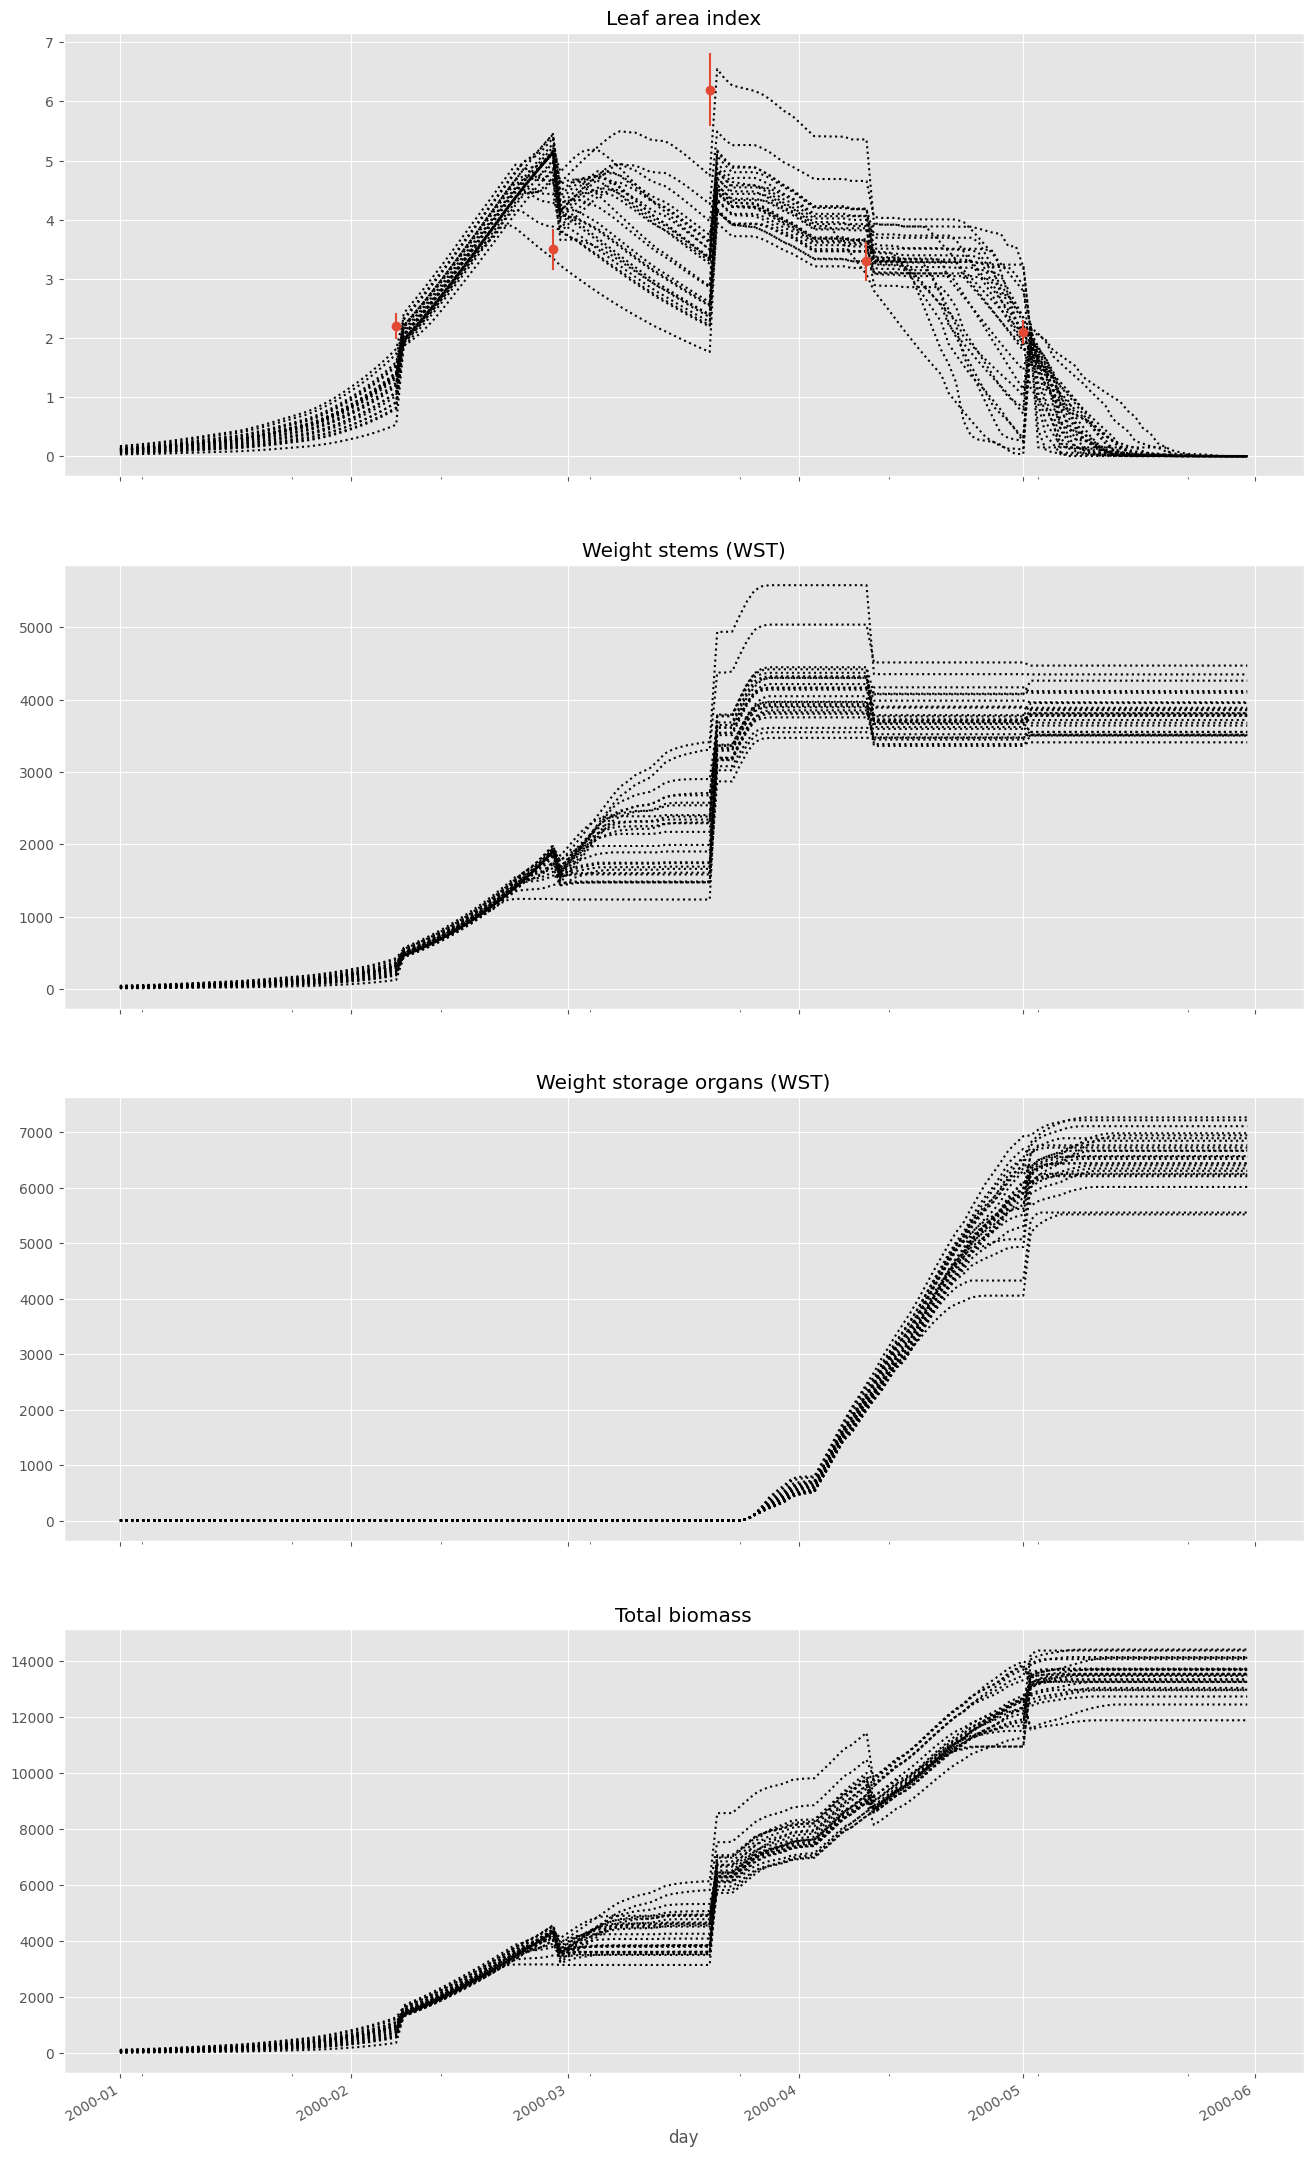

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,30), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["TWST"].plot(style="k:", ax=axes[1])
    member_df["TWSO"].plot(style="k:", ax=axes[2])
    member_df["TAGP"].plot(style="k:", ax=axes[3])
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Weight stems (WST)")
axes[2].set_title("Weight storage organs (WST)")
axes[3].set_title("Total biomass")
fig.autofmt_xdate()